# Outcome model with no stroke team

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

In [92]:
# Fields for model
X_fields = [
    'prior_disability',
    'stroke_severity',
    'stroke_team',
    'onset_to_thrombolysis',
    'age',
    'precise_onset_known',
    'any_afib_diagnosis'
    ]
# Load data and get X and y
data = pd.read_csv('./data/data_for_ml/complete_ml_data.csv', low_memory=False)
# Limit to infarction = 1
mask = data['infarction'] == 1
data = data[mask]
# Reindex
data = data.reset_index(drop=True)
stroke_teams = list(data['stroke_team'].unique())
stroke_teams.sort()
# Restrict to fields to use
fields_to_use = X_fields + ['discharge_disability']
data = data[fields_to_use]
# One hot encode stroke teams using OneHotEncoder with stroke_teams as categories
enc = OneHotEncoder(categories=[stroke_teams])
enc.fit(data[['stroke_team']])
one_hot = enc.transform(data[['stroke_team']]).toarray()
one_hot = pd.DataFrame(one_hot, columns=stroke_teams)
data = pd.concat([data, one_hot], axis=1)
data = data.drop(columns=['stroke_team'])

# Fit models
replicates = 10
model_full = []

for i in range(replicates):
    # Sample data
    sample = data.sample(frac=1.0, random_state=42+i, replace=True)
    X = sample.drop(columns=['discharge_disability'])
    y = sample['discharge_disability']
    # Fit full model
    model = XGBClassifier(random_state=42+i)
    model.fit(X, y)
    model_full.append(model)


In [90]:
patient = {
    'prior_disability': 0,
    'stroke_severity': 10,
    'stroke_team': "Addenbrooke's Hospital",
    'onset_to_thrombolysis': 120,
    'age': 75,
    'precise_onset_known': 0,
    'any_afib_diagnosis': 0
}

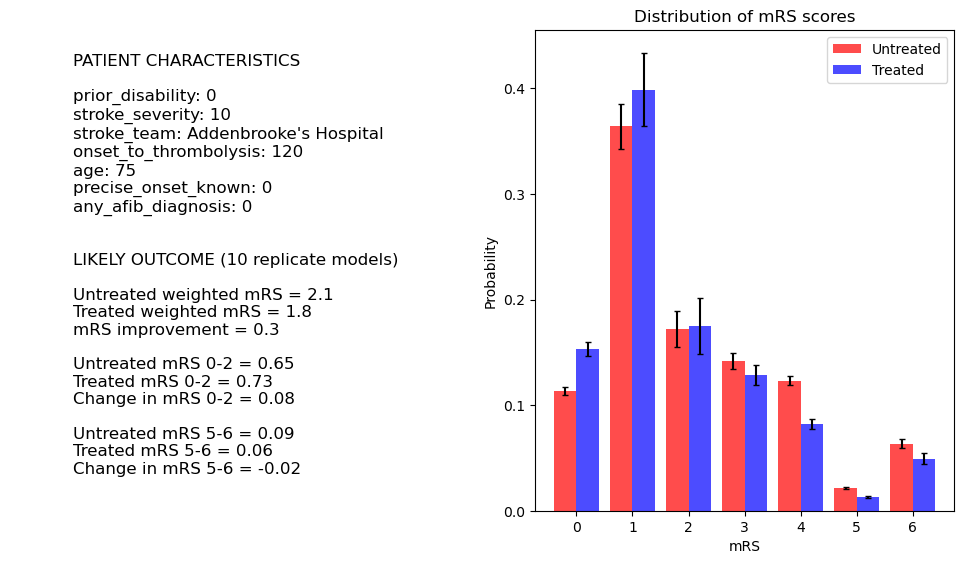

In [95]:
# Get predictions for patient
untreated_dist = []
treated_dist = []
untreated_less_3 = []
treated_less_3 = []
untreated_more_4 = []
treated_more_4 = []
untreated_weighted_mrs = []
treated_weighted_mrs = []
improvement = []

# Set up patient for predictions
patient = pd.DataFrame(patient, index=[0])
one_hot_encoded = enc.transform(patient[['stroke_team']]).toarray()
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=stroke_teams, index=[0])
patient_treated = pd.concat([patient, one_hot_encoded_df], axis=1)
patient_treated.drop('stroke_team', axis=1, inplace=True)
patient_untreated = patient_treated.copy()
patient_untreated['onset_to_thrombolysis'] = -10
untreated = model.predict_proba(pd.DataFrame(patient_untreated, index=[0]))[0]

for i in range(replicates):
    # Get untreated and treated distributions
    untreated = model_full[i].predict_proba(pd.DataFrame(patient_untreated, index=[0]))[0]
    treated = model_full[i].predict_proba(pd.DataFrame(patient_treated, index=[0]))[0]
    untreated_dist.append(untreated)
    treated_dist.append(treated)
    # Get weighted average of mRS scores
    weighted_untreated = np.sum(untreated * np.arange(7))
    weighted_treated = np.sum(treated * np.arange(7))
    untreated_weighted_mrs.append(weighted_untreated)
    treated_weighted_mrs.append(weighted_treated)
    improvement.append(0-(weighted_treated - weighted_untreated))
    # Get untreated and treated distributions for mRS <3
    untreated_less_3.append(np.sum(untreated[:3]))
    treated_less_3.append(np.sum(treated[:3]))
    # Get untreated and treated distributions for mRS >4
    untreated_more_4.append(np.sum(untreated[5:]))
    treated_more_4.append(np.sum(treated[5:]))

#### PLOT ####

# Convert patient to dataframe
patient = pd.DataFrame(patient, index=[0])


# Draw a dotted histogram of the untreated and treated distributions
fig = plt.figure(figsize=(10, 6))

# Add patient dictionary as a text box
ax = fig.add_subplot(121)
patient_dict = patient.iloc[0].to_dict()
patient_text = 'PATIENT CHARACTERISTICS\n\n'

patient_text = patient_text + (
    '\n'.join([f'{k}: {v}' for k, v in patient_dict.items()]))

patient_text = patient_text + f'\n\n\nLIKELY OUTCOME ({replicates} replicate models)\n'

v = np.mean(untreated_weighted_mrs)
patient_text = patient_text + f'\nUntreated weighted mRS = {v:0.1f}'
v = np.mean(treated_weighted_mrs)
patient_text = patient_text + f'\nTreated weighted mRS = {v:0.1f}'
v = np.mean(improvement)
patient_text = patient_text + f'\nmRS improvement = {v:0.1f}'

v = np.mean(untreated_less_3)
patient_text = patient_text + f'\n\nUntreated mRS 0-2 = {v:0.2f}'
v = np.mean(treated_less_3)
patient_text = patient_text + f'\nTreated mRS 0-2 = {v:0.2f}'
v = (np.mean(treated_less_3) - np.mean(untreated_less_3))
patient_text = patient_text + f'\nChange in mRS 0-2 = {v:0.2f}'

v = np.mean(untreated_more_4)
patient_text = patient_text + f'\n\nUntreated mRS 5-6 = {v:0.2f}'
v = np.mean(treated_more_4)
patient_text = patient_text + f'\nTreated mRS 5-6 = {v:0.2f}'
v = (np.mean(treated_more_4) - np.mean(untreated_more_4))
patient_text = patient_text + f'\nChange in mRS 5-6 = {v:0.2f}'


ax.text(0.15, 0.95, patient_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

# Remove all axes
ax.axis('off')

# Plot outcomes
ax = fig.add_subplot(122)
x = np.arange(7)
ax.bar(x-0.2, np.mean(untreated_dist, axis=0), 
       color='red', label=f'Untreated', linewidth=1, linestyle='--', width=0.4, alpha=0.7)
ax.bar(x+0.2, np.mean(treated_dist, axis=0),
       color='blue', label=f'Treated', linewidth=1, linestyle='--', width=0.4, alpha=0.7)
error_untreated = np.std(untreated_dist, axis=0) / np.sqrt(replicates)
error_treated = np.std(treated_dist, axis=0) / np.sqrt(replicates)
ax.errorbar(x-0.2, np.mean(untreated_dist, axis=0), yerr=error_untreated, 
            fmt='none', ecolor='black', capsize=2)
ax.errorbar(x+0.2, np.mean(treated_dist, axis=0), yerr=error_treated,
                fmt='none', ecolor='black', capsize=2)


ax.legend()
ax.set_xlabel('mRS')
ax.set_ylabel('Probability')
ax.set_title(f'Distribution of mRS scores')


plt.tight_layout(pad=2)
plt.show()